# NIRISS Imaging WCS validation for Camillas simulation images through grizli
Using NIRISS direct imaging simulated data, this notebook walks through creating the resampled mosaic, catalog, and checking the roundtrip of the pixel coordinates through the fits wcs and gwcs

In [1]:
# plotting, the inline must come before the matplotlib import
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches


# python general
import os
import numpy as np

# astropy modules
import astropy
from astropy.io import fits
from astropy.table import QTable
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord

# jwst 
import jwst
from jwst.source_catalog import source_catalog_step
from jwst.datamodels import image, DrizProductModel, ModelContainer
from jwst import assign_wcs
from jwst.assign_wcs import assign_wcs_step
from jwst.resample.resample_step import ResampleStep

In [2]:
print("Using jwst pipeline version: {}\nastropy version: {}".format(jwst.__version__, astropy.__version__ ))

Using jwst pipeline version: 0.12.0a.dev139
astropy version: 3.1.dev22571


In [3]:
#notebook_dir = os.environ['JWST_NOTEBOOK_DATA']
niriss_data = '/Users/sosey/ssb/jwst-pipeline/camilla/NIRISS-sims-agian/test_pipeline/images_2048/'

#Direct images
pos1 = niriss_data + 'niriss-sim-sept18-stars-2048-f150w-clear-pos1_rate.fits'
pos2 = niriss_data + 'niriss-sim-sept18-stars-2048-f150w-clear-pos2_rate.fits'
pos3 = niriss_data + 'niriss-sim-sept18-stars-2048-f150w-clear-pos3_rate.fits'
pos4 = niriss_data + 'niriss-sim-sept18-stars-2048-f150w-clear-pos4_rate.fits'

raw_scene = niriss_data + 'niriss-sim-sept18-stars-2048-f150w.fits'
resampled_mosaic = 'test_resample_image.fits'

save_figures = False
print("Running using data from: {} and save figures is {}".format(niriss_data, save_figures))

Running using data from: /Users/sosey/ssb/jwst-pipeline/camilla/NIRISS-sims-agian/test_pipeline/images_2048/ and save figures is False


### Display the dithered images chosen above

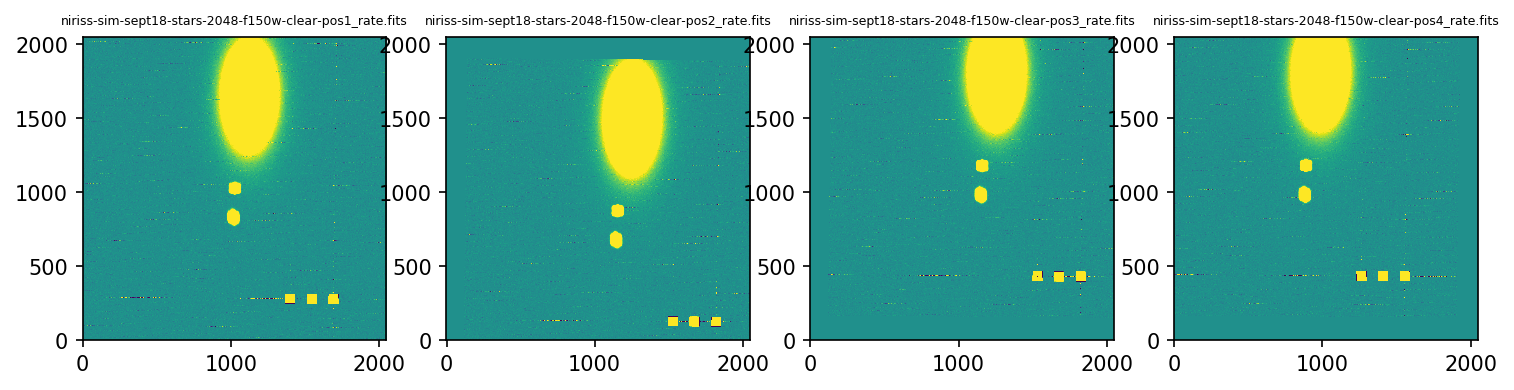

In [4]:
p1 = fits.getdata(pos1)
p2 = fits.getdata(pos2)
p3 = fits.getdata(pos3)
p4 = fits.getdata(pos4)

#xs, ys = dirim[1].data.shape
fig = plt.figure(figsize=(12,10), dpi=150)

ax = fig.add_subplot(1, 4, 1)
ax.set_title(pos1.split("/")[-1], fontsize=6)
ax.imshow(p1, origin='lower', vmin=-5e-6, vmax=5e-6)

ax2 = fig.add_subplot(1, 4, 2)
ax2.set_title(pos2.split("/")[-1], fontsize=6)
ax2.imshow(p2, origin='lower', vmin=-5e-6, vmax=5e-6)

ax3 = fig.add_subplot(1, 4, 3)
ax3.set_title(pos3.split("/")[-1], fontsize=6)
ax3.imshow(p3, origin='lower', vmin=-5e-6, vmax=5e-6)

ax4 = fig.add_subplot(1, 4, 4)
ax4.set_title(pos4.split("/")[-1], fontsize=6)
ax4.imshow(p4, origin='lower', vmin=-5e-6, vmax=5e-6)

if save_figures:
    fname = niriss_data.split("/")[1]+'-dither-display.jpg'
    fig.savefig(fname)
    print("Saved figure to {}".format(fname))

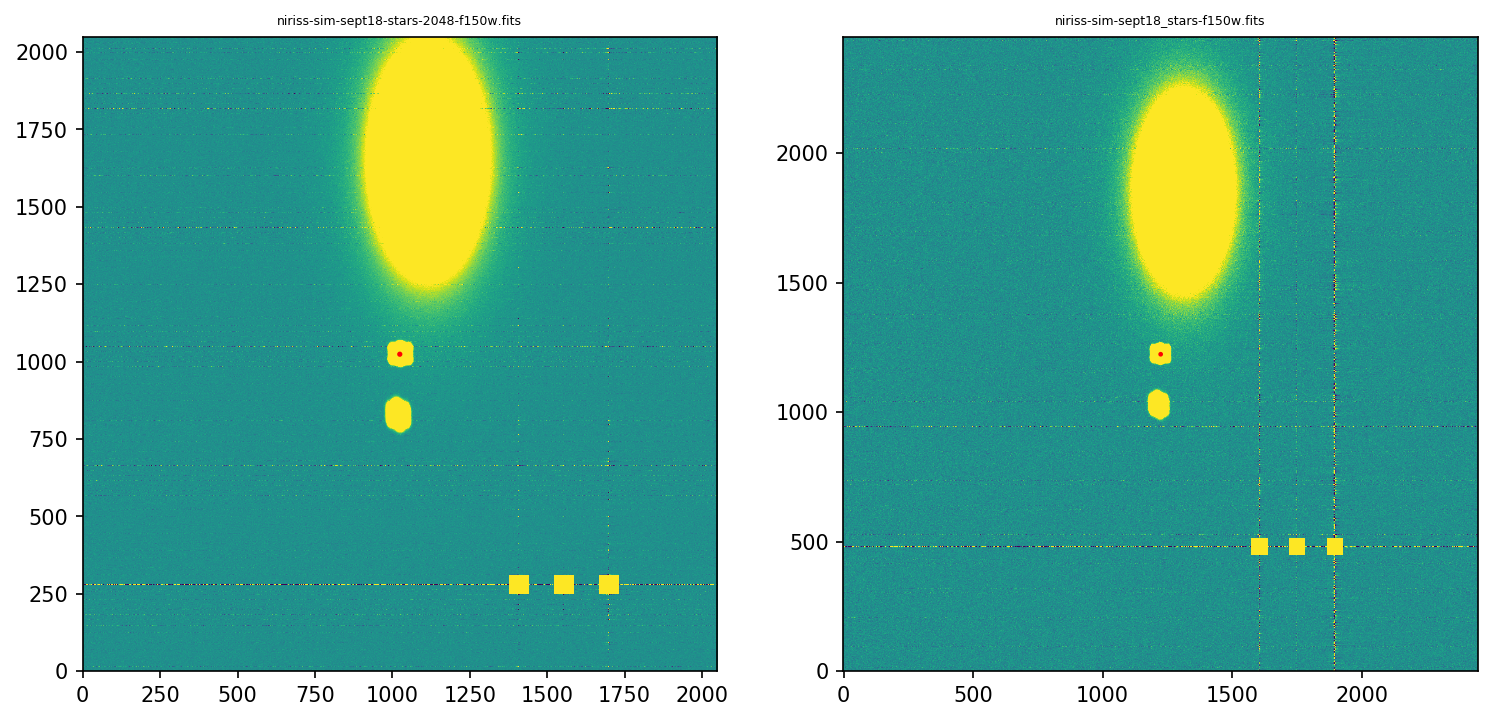

In [5]:
praw = fits.getdata(raw_scene)

large_raw = "../comparison/comparison/niriss-sim-sept18_stars-f150w.fits"
im_large_raw = fits.getdata(large_raw)

#xs, ys = dirim[1].data.shape
fig = plt.figure(figsize=(12,10), dpi=150)

ax = fig.add_subplot(1, 2, 1)
ax.set_title(raw_scene.split("/")[-1], fontsize=6)
ax.imshow(praw, origin='lower', vmin=-5e-6, vmax=5e-6)
plist1=(patches.Circle((1024, 1024),5, color='red'))
ax.add_patch(plist1)

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title(large_raw.split("/")[-1], fontsize=6)
ax2.imshow(im_large_raw, origin='lower', vmin=-5e-6, vmax=5e-6)
plist1=(patches.Circle((1224, 1224),5, color='red'))
ax2.add_patch(plist1)

#### Above, with the same CRVAL but different CRPIX the same object is found

In [6]:
from astropy.wcs import WCS
small_fits_wcs = WCS('raw')
large_fits_wcs = WCS('large_raw')

2018-10-05 18:12:04,785 - stpipe - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.5/site-packages/astropy/io/fits/card.py:711: AstropyUserWarning: The following header keyword is invalid or follows an unrecognized non-standard convention:
raw                                                                             
  self._image), AstropyUserWarning)

2018-10-05 18:12:04,786 - stpipe - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.5/site-packages/astropy/io/fits/card.py:711: AstropyUserWarning: The following header keyword is invalid or follows an unrecognized non-standard convention:
large_raw                                                                       
  self._image), AstropyUserWarning)



## We'll send the direct images through the assign_wcs to attached the wcs and distortion information
#### first we'll add the wcs to the objects

In [7]:
p1_model = image.ImageModel(pos1)
p2_model = image.ImageModel(pos2)
p3_model = image.ImageModel(pos3)
p4_model = image.ImageModel(pos4)

In [8]:
awcs = assign_wcs.AssignWcsStep()
pos1_wcs = awcs(p1_model)
pos2_wcs = awcs(p2_model)
pos3_wcs = awcs(p3_model)
pos4_wcs = awcs(p4_model)

model_container = ModelContainer([pos1_wcs, pos2_wcs, pos3_wcs, pos4_wcs])

2018-10-05 18:12:10,051 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2018-10-05 18:12:10,110 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from niriss-sim-sept18-stars-2048-f150w-clear-pos1_rate.fits>,).
2018-10-05 18:12:10,941 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  53.111622849 -27.975288986 53.112171132 -27.937849216 53.070063998 -27.937528703 53.069515071 -27.974999101
2018-10-05 18:12:10,942 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.111622849 -27.975288986 53.112171132 -27.937849216 53.070063998 -27.937528703 53.069515071 -27.974999101
2018-10-05 18:12:10,943 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2018-10-05 18:12:10,955 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done
2018-10-05 18:12:11,024 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from niriss-sim-sept18-stars-2048-f150w-clear-po

In [9]:
model_container.meta.filename = resampled_mosaic # save the resampled image here

## These are the poitings
from basic wcs information

In [10]:
p1_model.meta.wcsinfo.crval1, p1_model.meta.wcsinfo.crval2 , p1_model.meta.wcsinfo.ra_ref, p1_model.meta.wcsinfo.dec_ref

(53.090861, -27.95642, 53.090861, -27.95642)

In [11]:
p2_model.meta.wcsinfo.crval1, p2_model.meta.wcsinfo.crval2 , p2_model.meta.wcsinfo.ra_ref, p2_model.meta.wcsinfo.dec_ref

(53.09363887850647, -27.95364222222222, 53.09363887850647, -27.95364222222222)

In [12]:
p3_model.meta.wcsinfo.crval1, p3_model.meta.wcsinfo.crval2 , p3_model.meta.wcsinfo.ra_ref, p3_model.meta.wcsinfo.dec_ref

(53.09363887850647, -27.95919777777778, 53.09363887850647, -27.95919777777778)

In [13]:
p4_model.meta.wcsinfo.crval1, p4_model.meta.wcsinfo.crval2 , p4_model.meta.wcsinfo.ra_ref, p4_model.meta.wcsinfo.dec_ref

(53.08808312149353, -27.95919777777778, 53.08808312149353, -27.95919777777778)

## Let's do a quick check on a single image for WCS roundtrip through the distortion file

In [14]:
pos1_wcs.meta.wcs.available_frames

['detector', 'v2v3', 'world']

In [15]:
x,y = (100, 100)  # just pick a pixel

In [16]:
ra, dec = pos1_wcs.meta.wcs(x,y)

In [17]:
ra, dec

(53.109596595207044, -27.973449065997166)

In [18]:
xx,yy = pos1_wcs.meta.wcs.invert(ra, dec)

In [19]:
xx,yy  # that seems about the right roundtrip for the current niriss distortion reference file

(100.0165956184145, 99.99896534768311)

# Now for the resampling

In [20]:
resample_step = ResampleStep()

2018-10-05 18:12:18,482 - stpipe.ResampleStep - INFO - ResampleStep instance created.


In [21]:
driz_model = resample_step.call(model_container)

2018-10-05 18:12:18,651 - stpipe.ResampleStep - INFO - ResampleStep instance created.
2018-10-05 18:12:18,713 - stpipe.ResampleStep - INFO - Step ResampleStep running with args (<ModelContainer from test_resample_image.fits>,).
2018-10-05 18:12:18,722 - stpipe.ResampleStep - INFO - Drizpars reference file: /Users/sosey/crds_cache/references/jwst/niriss/jwst_niriss_drizpars_0002.fits
2018-10-05 18:12:19,266 - stpipe.ResampleStep - INFO - Blending metadata for None
2018-10-05 18:12:22,587 - stpipe.ResampleStep - INFO - Drizzling (2048, 2048) --> (2375, 2335)
2018-10-05 18:12:26,859 - stpipe.ResampleStep - INFO - Drizzling (2048, 2048) --> (2375, 2335)
2018-10-05 18:12:31,352 - stpipe.ResampleStep - INFO - Drizzling (2048, 2048) --> (2375, 2335)
2018-10-05 18:12:35,704 - stpipe.ResampleStep - INFO - Drizzling (2048, 2048) --> (2375, 2335)
2018-10-05 18:12:38,142 - stpipe.ResampleStep - INFO - Update S_REGION to POLYGON ICRS  53.115658675 -27.978777899 53.115649004 -27.935470163 53.0674548

In [22]:
driz_model.data.shape, driz_model.meta.wcsinfo.roll_ref, driz_model.meta.wcsinfo.ra_ref, driz_model.meta.wcsinfo.dec_ref, driz_model.meta.wcsinfo.crpix1, driz_model.meta.wcsinfo.crpix2

((2375, 2335),
 0.1648378612073009,
 53.091547917366725,
 -27.957121777427457,
 1168.694931257014,
 1188.7387534967424)

## Let's look at the resampled image
#### And plot where the CRPIX is located, the CRVAL will print for info

location calculated from CRVAL through GWCS: (1167.694931256239, 1187.73875349718)
The red circle is the location of CRPIX1, CRPIX2
The orange circle is the location of CRPIX1 through GWCS


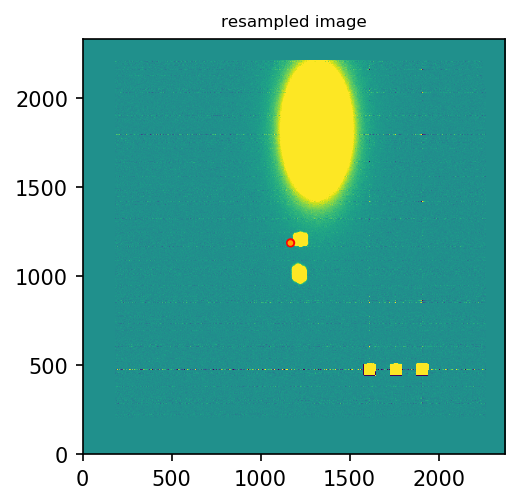

In [23]:
xs, ys = driz_model.data.shape
fig = plt.figure(figsize=(8,8), dpi=150)
ax = fig.add_subplot(1, 2, 1)
ax.set_title("resampled image", fontsize=8)
ax.imshow(driz_model.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)
plist=patches.Circle((driz_model.meta.wcsinfo.crpix1, driz_model.meta.wcsinfo.crpix2),20, color='red')
ax.add_patch(plist)
plist2=patches.Circle((driz_model.meta.wcs.invert(driz_model.meta.wcsinfo.crval1, driz_model.meta.wcsinfo.crval2)),10, color='orange')
ax.add_patch(plist2)
print("location calculated from CRVAL through GWCS: {}".format(driz_model.meta.wcs.invert(driz_model.meta.wcsinfo.crval1, driz_model.meta.wcsinfo.crval2)))
print("The red circle is the location of CRPIX1, CRPIX2")
print("The orange circle is the location of CRPIX1 through GWCS")

if save_figures:
    fname = resampled_mosaic + ".jpg"
    fig.savefig(fname)
    print("Saved image to {}".format(fname))
    


## CRPIX/CRVAL doesn't have to stay on an object, so this is fine

CRPIX pos1: 1024.5 1024.5  and CRVAL: 53.090861 -27.95642
CRPIX pos1: 1024.5 1024.5  and CRVAL: 53.09363887850647 -27.95364222222222
CRPIX pos1: 1024.5 1024.5  and CRVAL: 53.09363887850647 -27.95919777777778
CRPIX pos1: 1024.5 1024.5  and CRVAL: 53.08808312149353 -27.95919777777778

RESAMPLED IMAGE#  CRPIX 1168.694931257014 1188.7387534967424 and CRVAL 53.091547917366725 -27.957121777427457


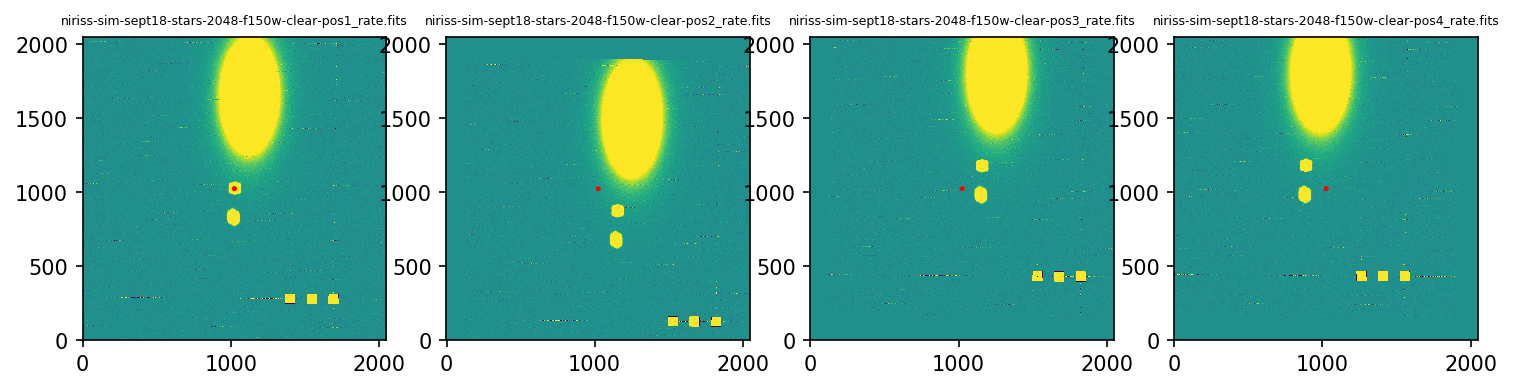

In [24]:
p1 = image.ImageModel(pos1)
p2 = image.ImageModel(pos2)
p3 = image.ImageModel(pos3)
p4 = image.ImageModel(pos4)

#xs, ys = dirim[1].data.shape
fig = plt.figure(figsize=(12,10), dpi=150)

ax = fig.add_subplot(1, 4, 1)
ax.set_title(pos1.split("/")[-1], fontsize=6)
ax.imshow(p1.data, origin='lower', vmin=-5e-6, vmax=5e-6)
plist=patches.Circle((p1.meta.wcsinfo.crpix1, p1.meta.wcsinfo.crpix2),10, color='red')
ax.add_patch(plist)

ax2 = fig.add_subplot(1, 4, 2)
ax2.set_title(pos2.split("/")[-1], fontsize=6)
ax2.imshow(p2.data, origin='lower', vmin=-5e-6, vmax=5e-6)
plist=patches.Circle((p2.meta.wcsinfo.crpix1, p2.meta.wcsinfo.crpix2),10, color='red')
ax2.add_patch(plist)

ax3 = fig.add_subplot(1, 4, 3)
ax3.set_title(pos3.split("/")[-1], fontsize=6)
ax3.imshow(p3.data, origin='lower', vmin=-5e-6, vmax=5e-6)
plist=patches.Circle((p3.meta.wcsinfo.crpix1, p3.meta.wcsinfo.crpix2),10, color='red')
ax3.add_patch(plist)

ax4 = fig.add_subplot(1, 4, 4)
ax4.set_title(pos4.split("/")[-1], fontsize=6)
ax4.imshow(p4.data, origin='lower', vmin=-5e-6, vmax=5e-6)
plist=patches.Circle((p4.meta.wcsinfo.crpix1, p4.meta.wcsinfo.crpix2),10, color='red')
ax4.add_patch(plist)

print("CRPIX pos1: {} {}  and CRVAL: {} {}".format(p1.meta.wcsinfo.crpix1, p1.meta.wcsinfo.crpix2,p1.meta.wcsinfo.crval1, p1.meta.wcsinfo.crval2))
print("CRPIX pos1: {} {}  and CRVAL: {} {}".format(p2.meta.wcsinfo.crpix1, p2.meta.wcsinfo.crpix2,p2.meta.wcsinfo.crval1, p2.meta.wcsinfo.crval2))
print("CRPIX pos1: {} {}  and CRVAL: {} {}".format(p3.meta.wcsinfo.crpix1, p3.meta.wcsinfo.crpix2,p3.meta.wcsinfo.crval1, p3.meta.wcsinfo.crval2))
print("CRPIX pos1: {} {}  and CRVAL: {} {}".format(p4.meta.wcsinfo.crpix1, p4.meta.wcsinfo.crpix2,p4.meta.wcsinfo.crval1, p4.meta.wcsinfo.crval2))
print()
print("RESAMPLED IMAGE#  CRPIX {} {} and CRVAL {} {}".format(driz_model.meta.wcsinfo.crpix1,
                                                             driz_model.meta.wcsinfo.crpix2,
                                                             driz_model.meta.wcsinfo.crval1,
                                                             driz_model.meta.wcsinfo.crval2))

if save_figures:
    fname = niriss_data.split("/")[1]+'-dithered-image-crpix.jpg'
    fig.savefig(fname)
    print("Saved figure to {}".format(fname))

### The location of the CRPIX is being held constant and the CRVALS are being updated with the dithers

# Now create a source catalog for the resampled mosaic image

In [25]:
driz_model.write(resampled_mosaic)
driz_model.close()

In [26]:
driz_model=DrizProductModel(resampled_mosaic)
driz_model.meta.filename

'test_resample_image.fits'

In [27]:
# optional parameters save their results to a file with the rootname of the image we loaded into the drizzle product model
sc=source_catalog_step.SourceCatalogStep()

2018-10-05 18:12:48,419 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.


In [28]:
print(sc.spec)  # display the defaults


        kernel_fwhm = float(default=2.0)      # Gaussian kernel FWHM in pixels
        kernel_xsize = float(default=5)       # Kernel x size in pixels
        kernel_ysize = float(default=5)       # Kernel y size in pixels
        snr_threshold = float(default=3.0)    # SNR threshold above the bkg
        npixels = float(default=5.0)          # min number of pixels in source
        deblend = boolean(default=False)      # deblend sources?
        output_ext = string(default='.ecsv')  # Default type of output
        suffix = string(default='cat')        # Default suffix for output files
    


In [29]:
catname = 'test_resample_image_resample_cat.ecsv'

In [30]:
save_results=sc.call(driz_model, save_results=True, output_file=catname, kernel_fwhm=3, npixels=50, deblend=True, snr_threshold=30)

2018-10-05 18:12:49,518 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2018-10-05 18:12:49,617 - stpipe.SourceCatalogStep - INFO - Step SourceCatalogStep running with args (<DrizProductModel(2375, 2335) from test_resample_image.fits>,).
2018-10-05 18:12:52,660 - stpipe.SourceCatalogStep - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.5/site-packages/astropy/io/fits/card.py:979: VerifyWarning: Card is too long, comment will be truncated.
  VerifyWarning)

2018-10-05 18:12:52,914 - stpipe.SourceCatalogStep - INFO - Detected 6 sources
2018-10-05 18:12:52,982 - stpipe.SourceCatalogStep - INFO - Wrote source catalog: test_resample_image_resample_cat.ecsv
2018-10-05 18:12:52,985 - stpipe.SourceCatalogStep - INFO - Step SourceCatalogStep done


## Open the source catalog that was used with this image
The catalog was saved to the notebook directory, not the data directory

In [31]:
catalog = QTable.read(catname,  format='ascii.ecsv')

In [32]:
catalog

<QTable length=6>
  id      xcentroid          ycentroid      ...  abmag  abmag_error
             pix                pix         ...                    
int64      float64            float64       ... float64   float32  
----- ------------------ ------------------ ... ------- -----------
    1  1580.730457387143  480.9707890013901 ...     nan         nan
    2 1725.6282954049163  480.9698626182533 ...     nan         nan
    3  1871.528968931652  480.9689154770703 ...     nan         nan
    4  1193.262947014079 1029.1290038612299 ...     nan         nan
    5  1199.997619372379  1225.456138606904 ...     nan         nan
    6 1290.1522712377246 1851.7259263753394 ...     nan         nan

## Overplot the sources on the image that the catalog was made from

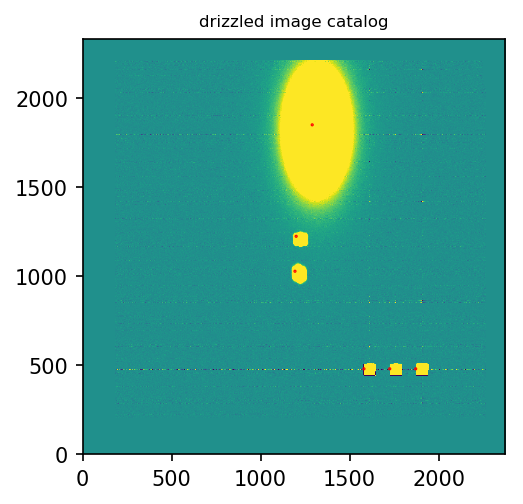

In [33]:
xs, ys = driz_model.data.shape
fig = plt.figure(figsize=(8,8), dpi=150)
ax = fig.add_subplot(1, 2, 2)
ax.set_title("drizzled image catalog", fontsize=8)
ax.imshow(driz_model.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)

# rectangle patches are xmin, ymin, width, height
plist1=[]
for obj in catalog:
    plist1.append(patches.Circle((obj['xcentroid'].value, obj['ycentroid'].value),3, color='red'))

for p in plist1:
    ax.add_patch(p)
    

## The source centers above are a little off because of source catalog settings

## Overplot the objects on the input images
This is using the catalog positions derived from the drizzled image, it should be representative of the shift used during the resample

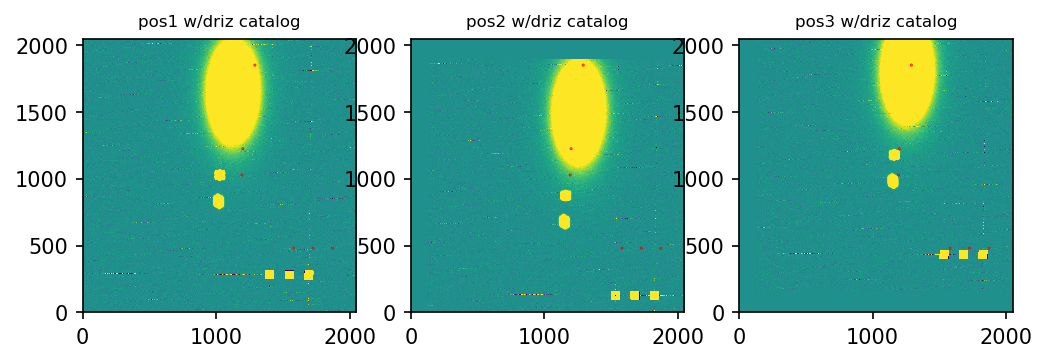

In [34]:
xs, ys = pos1_wcs.data.shape
fig = plt.figure(figsize=(8,8), dpi=150)
ax = fig.add_subplot(1, 3, 1)
ax.set_title("pos1 w/driz catalog", fontsize=8)
ax.imshow(pos1_wcs.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("pos2 w/driz catalog", fontsize=8)
ax2.imshow(pos2_wcs.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("pos3 w/driz catalog", fontsize=8)
ax3.imshow(pos3_wcs.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)


# rectangle patches are xmin, ymin, width, height
plist1=[]
plist2=[]
plist3=[]
for obj in catalog:
    plist1.append(patches.Circle((obj['xcentroid'].value, obj['ycentroid'].value),3, color='red'))
    plist2.append(patches.Circle((obj['xcentroid'].value, obj['ycentroid'].value),3, color='red'))
    plist3.append(patches.Circle((obj['xcentroid'].value, obj['ycentroid'].value),3, color='red'))

for p1,p2,p3 in zip(plist1,plist2,plist3):
    ax.add_patch(p1)
    ax2.add_patch(p2)
    ax3.add_patch(p3)

### Check the WCS information in our test images

In [35]:
driz_model.meta.instrument.name, driz_model.meta.instrument.filter, driz_model.meta.instrument.pupil, driz_model.meta.instrument.module, driz_model.meta.exposure.type

('NIRISS', 'CLEAR', 'F150W', None, 'NIS_IMAGE')

In [36]:
driz_model.meta.instrument.channel ='N/A'  # required for strict validation of the datamodel

## This is what source catalog is using to translate the pixel centers to sky coordinates, the FITS wcs in astropy

In [37]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs.utils import pixel_to_skycoord

In [38]:
wcs = driz_model.get_fits_wcs()
print("{} --> {}".format(catalog['sky_centroid'][0], skycoord_to_pixel(catalog['sky_centroid'][0], wcs, origin=0)))

2018-10-05 18:13:04,712 - stpipe - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.5/site-packages/astropy/io/fits/card.py:979: VerifyWarning: Card is too long, comment will be truncated.
  VerifyWarning)



<SkyCoord (ICRS): (ra, dec) in deg
    (53.08302018, -27.97000931)> --> (array(1580.73045739), array(480.970789))


In [39]:
junk=skycoord_to_pixel(catalog['sky_centroid'][0], wcs, origin=0)
print("{} --> {}".format(junk, pixel_to_skycoord(junk[0],junk[1], wcs, origin=0)))

(array(1580.73045739), array(480.970789)) --> <SkyCoord (ICRS): (ra, dec) in deg
    (53.08302018, -27.97000931)>


In [40]:
ra,dec = wcs.all_pix2world(1580.73045195, 480.97078861, 0)

In [41]:
wcs.all_world2pix(ra, dec, 0)

[array(1580.73045195), array(480.97078861)]

## Compare with what GWCS produces
GWCS is including the distortion correction in the chain from sky->detector->sky before drizzling, after drizzling it should match the FITS wcs. 

#### Note: the `detector` frame here represents distorted pixel locations on the detector. These are the pixel locations that should be used to go through the grism trace polynomials to find the positions of the same object+wavelength on the grism exposure

In [42]:
driz_model.meta.wcsinfo.v2_ref, driz_model.meta.wcsinfo.v3_ref, driz_model.meta.wcsinfo.roll_ref, driz_model.meta.wcsinfo.ra_ref, driz_model.meta.wcsinfo.dec_ref

(-290.1, -697.5, 0.1648378612073009, 53.09154791736673, -27.95712177742746)

In [43]:
driz_model.meta.wcs.available_frames

['detector', 'world']

In [44]:
world_to_detector = driz_model.meta.wcs.get_transform('world','detector')
detector_to_world = driz_model.meta.wcs.get_transform('detector', 'world')

In [45]:
catalog[0]

<Row index=0>
  id      xcentroid         ycentroid                  sky_centroid               area  source_sum source_sum_err semimajor_axis_sigma semiminor_axis_sigma     orientation                  sky_bbox_ll                            sky_bbox_ul                           sky_bbox_lr                           sky_bbox_ur               orientation_sky    abmag  abmag_error
             pix               pix                       deg,deg                  pix2                                    pix                  pix                  deg                        deg,deg                                deg,deg                               deg,deg                               deg,deg                       deg                            
int64      float64           float64                      object                float64  float32      float32           float64              float64              float64                       object                                 object                                object                                object                     float64       float64   float32  
----- ----------------- ----------------- ------------------------------------- ------- ---------- -------------- -------------------- -------------------- ------------------- -------------------------------------- ------------------------------------- ------------------------------------- ------------------------------------- ------------------ ------- -----------
    1 1580.730457387143 480.9707890013901 53.08302018432123,-27.970009314090163  4812.0   4679.397       4.948804   3.8454351325056826    3.298085420753952 -1.8047440346723702 53.083726877496105,-27.970637925091054 53.08372696998316,-27.969361486465843 53.08228161493941,-27.970637835819655 53.08228172451729,-27.969361397199265 268.19525596532765     nan         nan

## FITS wcs gives array(1580.73045195), array(480.97078861) for first object and the GWCS result below is really close to that as well

In [46]:
ra, dec = (53.083020184433515,-27.970009314097243)
world_to_detector(ra, dec)

(1580.730451947144, 480.97078861373154)

In [47]:
print("\nRound tripping the pixel values using GWCS\n")
olist=catalog[:5]
delx=0
dely=0
for obj in olist:
    x = obj['xcentroid'].value
    y = obj['ycentroid'].value
    ra = obj['sky_centroid'].ra.value
    dec = obj['sky_centroid'].dec.value
    w2dx, w2dy = world_to_detector(ra, dec)
    d2wra, d2wdec = detector_to_world(w2dx, w2dy)
    delx = delx + np.abs(x-w2dx)
    dely = dely + np.abs(y-w2dy)
    print("\nid:{}\nx: {} -> {}\ny: {} -> {}\nra: {}-> {}\ndec: {} -> {}".format(obj['id'], x,w2dx, y, w2dy, ra, d2wra, dec, d2wdec))
print("\nAvg. x difference: {}\nAvg. y difference: {}".format(delx/len(olist), dely/len(olist)))


Round tripping the pixel values using GWCS


id:1
x: 1580.730457387143 -> 1580.730457385751
y: 480.9707890013901 -> 480.97078900171834
ra: 53.08302018432123-> 53.08302018432123
dec: -27.970009314090163 -> -27.970009314090163

id:2
x: 1725.6282954049163 -> 1725.6282954044163
y: 480.9698626182533 -> 480.9698626179321
ra: 53.0800285529116-> 53.08002855291161
dec: -27.970009114190166 -> -27.970009114190155

id:3
x: 1871.528968931652 -> 1871.528968931084
y: 480.9689154770703 -> 480.968915476995
ra: 53.07701621653365-> 53.07701621653364
dec: -27.97000884779104 -> -27.970008847791032

id:4
x: 1193.262947014079 -> 1193.2629470129918
y: 1029.1290038612299 -> 1029.129003861067
ra: 53.09102007651148-> 53.09102007651148
dec: -27.960013999602275 -> -27.96001399960228

id:5
x: 1199.997619372379 -> 1199.9976193719615
y: 1225.456138606904 -> 1225.4561386072698
ra: 53.090881064168535-> 53.090881064168535
dec: -27.956434005390832 -> -27.956434005390832

Avg. x difference: 7.928974810056388e-10
Avg. y d

## Let's use the catalog sky coordinate  to translate the location to the original images

In [48]:
ra, dec  # for the first object

(53.090881064168535, -27.956434005390832)

In [49]:
# get the translation from one image:
x, y = pos1_wcs.meta.wcs.invert(ra, dec)
x, y

(1022.5145172977566, 1022.7427772929633)

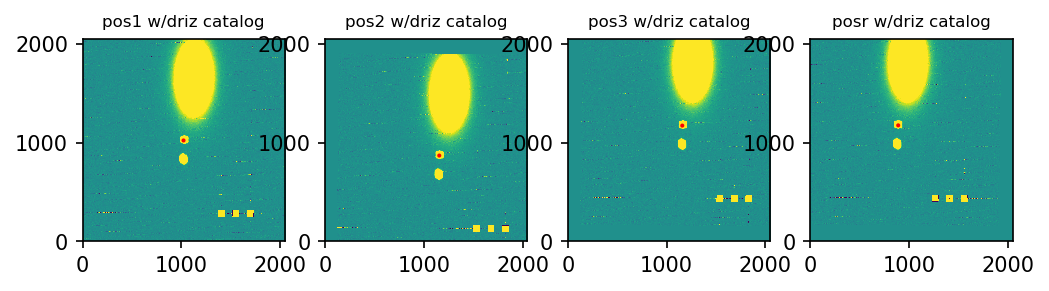

In [50]:
xs, ys = pos1_wcs.data.shape
fig = plt.figure(figsize=(8,8), dpi=150)
ax = fig.add_subplot(1, 4, 1)
ax.set_title("pos1 w/driz catalog", fontsize=8)
ax.imshow(pos1_wcs.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)
ax.add_patch(patches.Circle(pos1_wcs.meta.wcs.invert(ra, dec), 10, color='red'))

ax2 = fig.add_subplot(1, 4, 2)
ax2.set_title("pos2 w/driz catalog", fontsize=8)
ax2.imshow(pos2_wcs.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)
ax2.add_patch(patches.Circle(pos2_wcs.meta.wcs.invert(ra, dec), 10, color='red'))

ax3 = fig.add_subplot(1, 4, 3)
ax3.set_title("pos3 w/driz catalog", fontsize=8)
ax3.imshow(pos3_wcs.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)
ax3.add_patch(patches.Circle(pos3_wcs.meta.wcs.invert(ra, dec), 10, color='red'))

ax4 = fig.add_subplot(1, 4, 4)
ax4.set_title("posr w/driz catalog", fontsize=8)
ax4.imshow(pos4_wcs.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)
ax4.add_patch(patches.Circle(pos4_wcs.meta.wcs.invert(ra, dec), 10, color='red'))


### Resample the other positions

In [51]:
driz_single = resample_step.call(pos1_wcs)
driz_single2 = resample_step.call(pos2_wcs)
driz_single3 = resample_step.call(pos3_wcs)
driz_single4 = resample_step.call(pos4_wcs)

2018-10-05 18:13:13,271 - stpipe.ResampleStep - INFO - ResampleStep instance created.
2018-10-05 18:13:13,384 - stpipe.ResampleStep - INFO - Step ResampleStep running with args (<ImageModel(2048, 2048) from niriss-sim-sept18-stars-2048-f150w-clear-pos1_rate.fits>,).
2018-10-05 18:13:13,424 - stpipe.ResampleStep - INFO - Drizpars reference file: /Users/sosey/crds_cache/references/jwst/niriss/jwst_niriss_drizpars_0002.fits
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2018-10-05 18:13:16,028 - stpipe.ResampleStep - INFO - Drizzling (2048, 2048) --> (2071, 2066)
2018-10-05 18:13:18,488 - stpipe.ResampleStep - INFO - Update S_REGION to POLYGON ICRS  53.112185180 -27.975305801 53.112177719 -27.937541455 53.0695349

## Let's look at the resampled images and plot the resampled catalog position over  the large resampled image

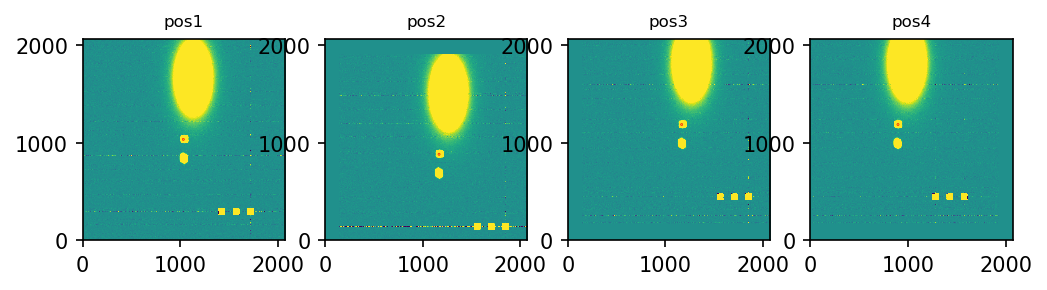

In [52]:
xs, ys = driz_single.data.shape
fig = plt.figure(figsize=(8,8), dpi=150)

ax = fig.add_subplot(1, 4, 1)
ax.set_title("pos1", fontsize=8)
ax.imshow(driz_single.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)
plist = patches.Circle(driz_single.meta.wcs.invert(ra, dec), 3, color='red')
ax.add_patch(plist)

ax2 = fig.add_subplot(1, 4, 2)
ax2.set_title("pos2", fontsize=8)
ax2.imshow(driz_single2.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)
plist = patches.Circle(driz_single2.meta.wcs.invert(ra, dec), 3, color='red')
ax2.add_patch(plist)

ax3 = fig.add_subplot(1, 4, 3)
ax3.set_title("pos3", fontsize=8)
ax3.imshow(driz_single3.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)
plist = patches.Circle(driz_single3.meta.wcs.invert(ra, dec), 3, color='red')
ax3.add_patch(plist)

ax4 = fig.add_subplot(1, 4, 4)
ax4.set_title("pos4", fontsize=8)
ax4.imshow(driz_single4.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)
plist = patches.Circle(driz_single4.meta.wcs.invert(ra, dec), 3, color='red')
ax4.add_patch(plist)



# Compare the RAW input image to the dithers

2018-10-05 18:13:38,417 - stpipe - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.5/site-packages/astropy/wcs/wcs.py:497: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
  wcsprm.naxis, header_naxis), FITSFixedWarning)

2018-10-05 18:13:38,788 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from niriss-sim-sept18-stars-2048-f150w-clear-pos1_rate.fits>,).
2018-10-05 18:13:39,179 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  53.111622849 -27.975288986 53.112171132 -27.937849216 53.070063998 -27.937528703 53.069515071 -27.974999101
2018-10-05 18:13:39,180 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.111622849 -27.975288986 53.112171132 -27.937849216 53.070063998 -27.937528703 53.069515071 -27.974999101
2018-10-05 18:13:39,180 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2018-10-05 18:13:39,189 - stpipe.AssignWcsStep - I

/Users/sosey/ssb/jwst-pipeline/camilla/NIRISS-sims-agian/test_pipeline/images_2048/niriss-sim-sept18-stars-2048-f150w.fits shape (2048, 2048)
/Users/sosey/ssb/jwst-pipeline/camilla/NIRISS-sims-agian/test_pipeline/images_2048/niriss-sim-sept18-stars-2048-f150w-clear-pos1_rate.fits shape (2048, 2048)


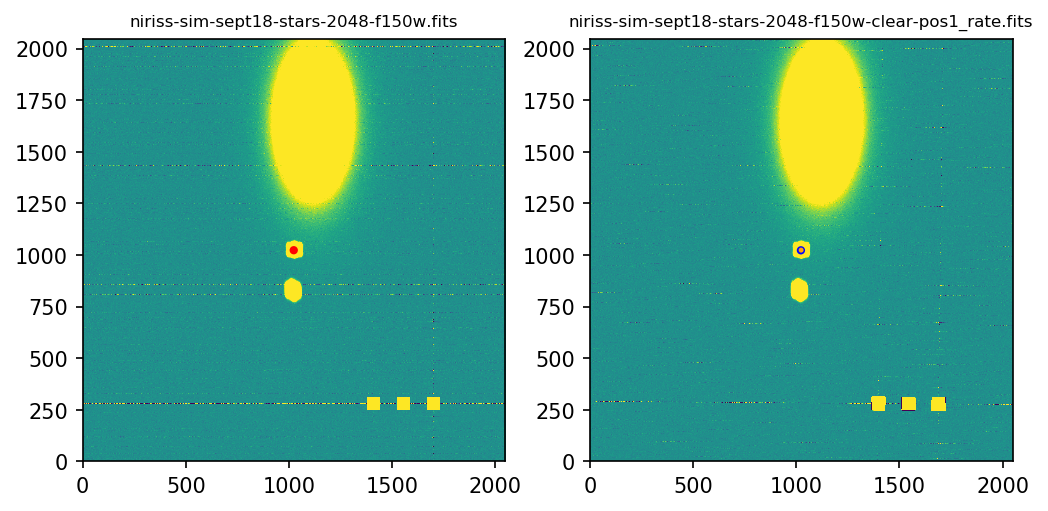

In [53]:
from astropy.wcs import WCS
raw_data = fits.getdata(raw_scene)  # starting image scene
dithered_pos1 = fits.getdata(pos1)  # first dither position should be at same location

raw_data_wcs = WCS(raw_scene)
dithered_pos1_wcs = WCS(pos1)

fig = plt.figure(figsize=(8,8), dpi=150)

ax = fig.add_subplot(1, 2, 1)
xs, ys = raw_data.shape
ax.set_title(raw_scene.split('/')[-1], fontsize=8)
ax.imshow(raw_data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)
ax.add_patch(patches.Circle(raw_data_wcs.all_world2pix(ra,dec,1), 15, color='red'))

ax2 = fig.add_subplot(1, 2, 2)
xs, ys = dithered_pos1.shape
ax2.set_title(pos1.split("/")[-1], fontsize=8)
ax2.imshow(dithered_pos1, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)
ax2.add_patch(patches.Circle(dithered_pos1_wcs.all_world2pix(ra,dec,1), 5, color='red'))

dithered = image.ImageModel(pos1)
dithered_pos1_wcs = awcs(dithered)

ax2.add_patch(patches.Circle(dithered_pos1_wcs.meta.wcs.invert(ra,dec), 15, color='blue'))
print("{} shape {}\n{} shape {}".format(raw_scene, raw_data.shape, pos1, dithered_pos1.shape))

junk = dithered_pos1_wcs.get_fits_wcs()
ax2.add_patch(patches.Circle(junk.all_world2pix(ra, dec,1), 7, color='orange'))

###  the FITS WCS can't be read by astropy wcs, use get_fits_wcs(), the blue dot is made with GWCS, the orange dot made with the fits wcs object returned by get_fits_wcs()


In [54]:
WCS(pos1)

2018-10-05 18:13:44,731 - stpipe - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.5/site-packages/astropy/wcs/wcs.py:497: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
  wcsprm.naxis, header_naxis), FITSFixedWarning)



WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 0  0

In [55]:
dithered_pos1_wcs.get_fits_wcs()

2018-10-05 18:13:47,765 - stpipe - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.5/site-packages/astropy/io/fits/card.py:979: VerifyWarning: Card is too long, comment will be truncated.
  VerifyWarning)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.090861  -27.95642  
CRPIX : 1024.5  1024.5  
PC1_1 PC1_2  : -1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.81662555555555e-05  1.83036805555555e-05  
NAXIS : 2048  2048

In [56]:
fits.info(pos1)

Filename: /Users/sosey/ssb/jwst-pipeline/camilla/NIRISS-sims-agian/test_pipeline/images_2048/niriss-sim-sept18-stars-2048-f150w-clear-pos1_rate.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     233   ()      
  1  SCI           1 ImageHDU        48   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  6  ASDF          1 BinTableHDU     11   5877R x 1C   [B]   


In [57]:
import asdf
a=asdf.open(pos1)
wcsinfo = a.tree['meta']['wcsinfo']
a.close()
wcsinfo

{'cdelt1': 1.81662555555555e-05,
 'cdelt2': 1.83036805555555e-05,
 'crpix1': 1024.5,
 'crpix2': 1024.5,
 'crval1': 53.090861,
 'crval2': -27.95642,
 'ctype1': 'RA---TAN',
 'ctype2': 'DEC--TAN',
 'cunit1': 'deg',
 'cunit2': 'deg',
 'dec_ref': -27.95642,
 'pc1_1': -1.0,
 'pc1_2': 0.0,
 'pc2_1': 0.0,
 'pc2_2': 1.0,
 'ra_ref': 53.090861,
 'roll_ref': 0.1648378612073009,
 's_region': 'POLYGON ICRS  86.45553476174035 -63.69690403464576 86.37156667618402 -63.69701233356545 86.37103131374535 -63.659511445837936 86.45487260473746 -63.65943493481796',
 'v2_ref': -290.1,
 'v3_ref': -697.5,
 'v3yangle': -0.569986,
 'vparity': -1,
 'wcsaxes': 2}

### Lets make a catalog using the dither position 1 image as input

In [58]:
# optional parameters save their results to a file with the rootname of the image we loaded into the drizzle product model
sc2=source_catalog_step.SourceCatalogStep()

2018-10-05 18:13:50,258 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.


In [59]:
print(sc2.spec)  # display the defaults


        kernel_fwhm = float(default=2.0)      # Gaussian kernel FWHM in pixels
        kernel_xsize = float(default=5)       # Kernel x size in pixels
        kernel_ysize = float(default=5)       # Kernel y size in pixels
        snr_threshold = float(default=3.0)    # SNR threshold above the bkg
        npixels = float(default=5.0)          # min number of pixels in source
        deblend = boolean(default=False)      # deblend sources?
        output_ext = string(default='.ecsv')  # Default type of output
        suffix = string(default='cat')        # Default suffix for output files
    


In [60]:
catname = 'test_comparison_image_raw'

In [61]:
fits.info(pos1)

Filename: /Users/sosey/ssb/jwst-pipeline/camilla/NIRISS-sims-agian/test_pipeline/images_2048/niriss-sim-sept18-stars-2048-f150w-clear-pos1_rate.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     233   ()      
  1  SCI           1 ImageHDU        48   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  6  ASDF          1 BinTableHDU     11   5877R x 1C   [B]   


In [62]:
# execute to add WHT extension to dataset- DrizProdModel expects this, and source_catalog requires this model for input
fits_pos1 = fits.open(pos1)
outname = pos1 + "_updated.fits"
WHT = False
for extname in fits_pos1:
    if 'WHT' in extname.name:
        WHT = True
if not WHT:
    wht_hdu = fits.ImageHDU()
    wht_hdu.data = np.ones((fits_pos1['SCI'].data.shape[1], fits_pos1['SCI'].data.shape[0]), dtype=np.float32)
    wht_hdu.header['EXTNAME'] = 'WHT'
else:
    print("WHT extension already exists, no update")
fits_pos1.append(wht_hdu)
fits_pos1.writeto(outname, overwrite=True)
print("Saved image to {}".format(outname))

Saved image to /Users/sosey/ssb/jwst-pipeline/camilla/NIRISS-sims-agian/test_pipeline/images_2048/niriss-sim-sept18-stars-2048-f150w-clear-pos1_rate.fits_updated.fits


In [63]:
drizmodel_pos1 = DrizProductModel(outname)
drizmodel_pos1 = DrizProductModel(outname)
drizmodel_pos1.meta.resample.product_exposure_time = 1
drizmodel_pos1.meta.exposure.exposure_time = 1
# source catalog is using get_fits_wcs() and that barfs on the DrizProdModel if validation fails on VAR_POISSON and VAR_RNOISE
# those don't exist are set to unloaded arrays in the model, so here  we'll set them.
drizmodel_pos1.var_poisson = 0
drizmodel_pos1.var_rnoise = 0

save_results2=sc2.call(drizmodel_pos1, save_results=True, output_file=catname, kernel_fwhm=3, npixels=50, deblend=False, snr_threshold=30)

2018-10-05 18:14:01,545 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2018-10-05 18:14:01,653 - stpipe.SourceCatalogStep - INFO - Step SourceCatalogStep running with args (<DrizProductModel(2048, 2048) from niriss-sim-sept18-stars-2048-f150w-clear-pos1_rate.fits_updated.fits>,).
2018-10-05 18:14:02,814 - stpipe.SourceCatalogStep - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.5/site-packages/astropy/io/fits/card.py:979: VerifyWarning: Card is too long, comment will be truncated.
  VerifyWarning)

2018-10-05 18:14:03,024 - stpipe.SourceCatalogStep - INFO - Detected 6 sources
2018-10-05 18:14:03,090 - stpipe.SourceCatalogStep - INFO - Wrote source catalog: test_comparison_image_raw_cat.ecsv
2018-10-05 18:14:03,092 - stpipe.SourceCatalogStep - INFO - Step SourceCatalogStep done


## Open the source catalog that was created for this image


In [64]:
catname = catname + "_cat.ecsv"

In [65]:
catalog = QTable.read(catname,  format='ascii.ecsv')

In [66]:
catalog

<QTable length=6>
  id      xcentroid          ycentroid      ...  abmag  abmag_error
             pix                pix         ...                    
int64      float64            float64       ... float64   float32  
----- ------------------ ------------------ ... ------- -----------
    1   1686.87699585235  275.7228489963896 ...     nan         nan
    2  1540.464779912591  276.7888829093276 ...     nan         nan
    3 1395.0481462815344   277.868428146018 ...     nan         nan
    4 1013.2205726922084   827.202384444367 ...     nan         nan
    5 1022.5081373136995 1022.7471338584969 ...     nan         nan
    6  1121.054701978226 1646.0289472395802 ...     nan         nan

## Overplot the sources on the image that the catalog was made from

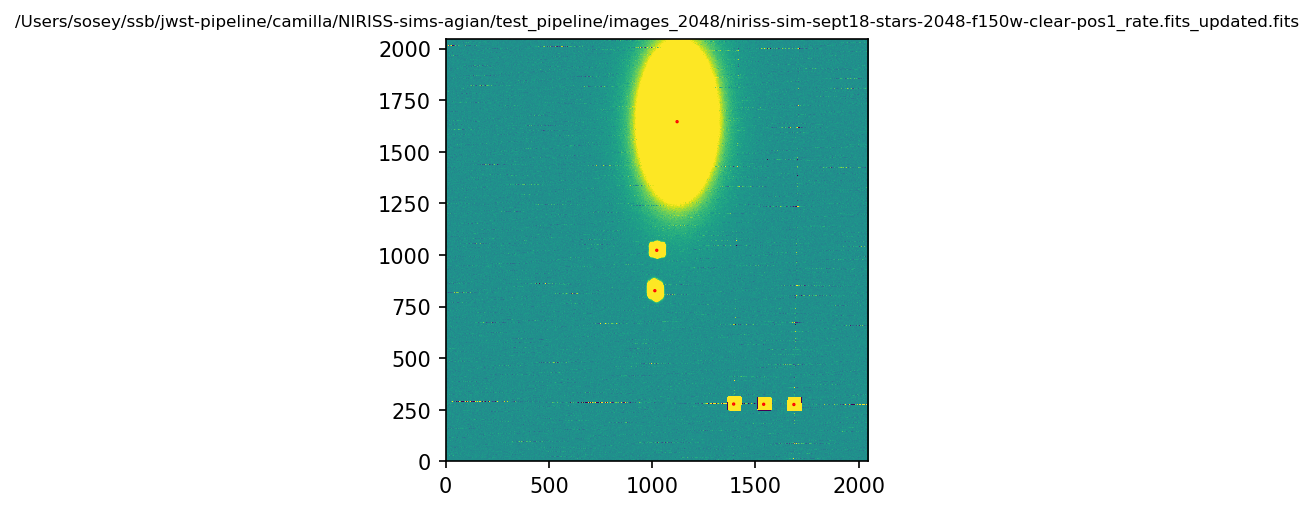

In [67]:
xs, ys = drizmodel_pos1.data.shape
fig = plt.figure(figsize=(8,8), dpi=150)
ax = fig.add_subplot(1, 2, 2)
ax.set_title(outname, fontsize=8)
ax.imshow(drizmodel_pos1.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)

# rectangle patches are xmin, ymin, width, height
plist1=[]
for obj in catalog:
    plist1.append(patches.Circle((obj['xcentroid'].value, obj['ycentroid'].value),3, color='red'))
for p in plist1:
    ax.add_patch(p)
    

## Overplot the sources on the other dithered images, using the GWCS object and the FITS wcs to translate to pixel coordinates

In [68]:
pos1_image = image.ImageModel(pos1)
pos2_image = image.ImageModel(pos2)
pos3_image = image.ImageModel(pos3)
pos4_image = image.ImageModel(pos4)

pos1_image_wcs = awcs(pos1_image)
pos2_image_wcs = awcs(pos2_image)
pos3_image_wcs = awcs(pos3_image)
pos4_image_wcs = awcs(pos4_image)

2018-10-05 18:14:42,959 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from niriss-sim-sept18-stars-2048-f150w-clear-pos1_rate.fits>,).
2018-10-05 18:14:43,340 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  53.111622849 -27.975288986 53.112171132 -27.937849216 53.070063998 -27.937528703 53.069515071 -27.974999101
2018-10-05 18:14:43,341 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.111622849 -27.975288986 53.112171132 -27.937849216 53.070063998 -27.937528703 53.069515071 -27.974999101
2018-10-05 18:14:43,341 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2018-10-05 18:14:43,353 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done
2018-10-05 18:14:43,451 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from niriss-sim-sept18-stars-2048-f150w-clear-pos2_rate.fits>,).
2018-10-05 18:14:43,850 - stpipe.AssignWcsStep - INFO - Update S_REGION

In [69]:
resampled_mosaic_catalog = 'test_resample_image_resample_cat.ecsv'

In [70]:
resampled_catalog = QTable.read(resampled_mosaic_catalog)

In [71]:
resampled_catalog

<QTable length=6>
  id      xcentroid          ycentroid      ...  abmag  abmag_error
             pix                pix         ...                    
int64      float64            float64       ... float64   float32  
----- ------------------ ------------------ ... ------- -----------
    1  1580.730457387143  480.9707890013901 ...     nan         nan
    2 1725.6282954049163  480.9698626182533 ...     nan         nan
    3  1871.528968931652  480.9689154770703 ...     nan         nan
    4  1193.262947014079 1029.1290038612299 ...     nan         nan
    5  1199.997619372379  1225.456138606904 ...     nan         nan
    6 1290.1522712377246 1851.7259263753394 ...     nan         nan

2018-10-05 18:14:48,908 - stpipe - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.5/site-packages/astropy/io/fits/card.py:979: VerifyWarning: Card is too long, comment will be truncated.
  VerifyWarning)



Object detected at 1022.5081373136995 1022.7471338584969
53.090881064168535 -27.956434005390832 --> 1022.5244127918161 1022.734831910244
53.090881064168535 -27.956434005390832 --> 1157.5941883563216 870.9727175180792
53.090881064168535 -27.956434005390832 --> 1157.5941883527394 1174.4939433752802
53.090881064168535 -27.956434005390832 --> 887.4546372252616 1174.4938993607939


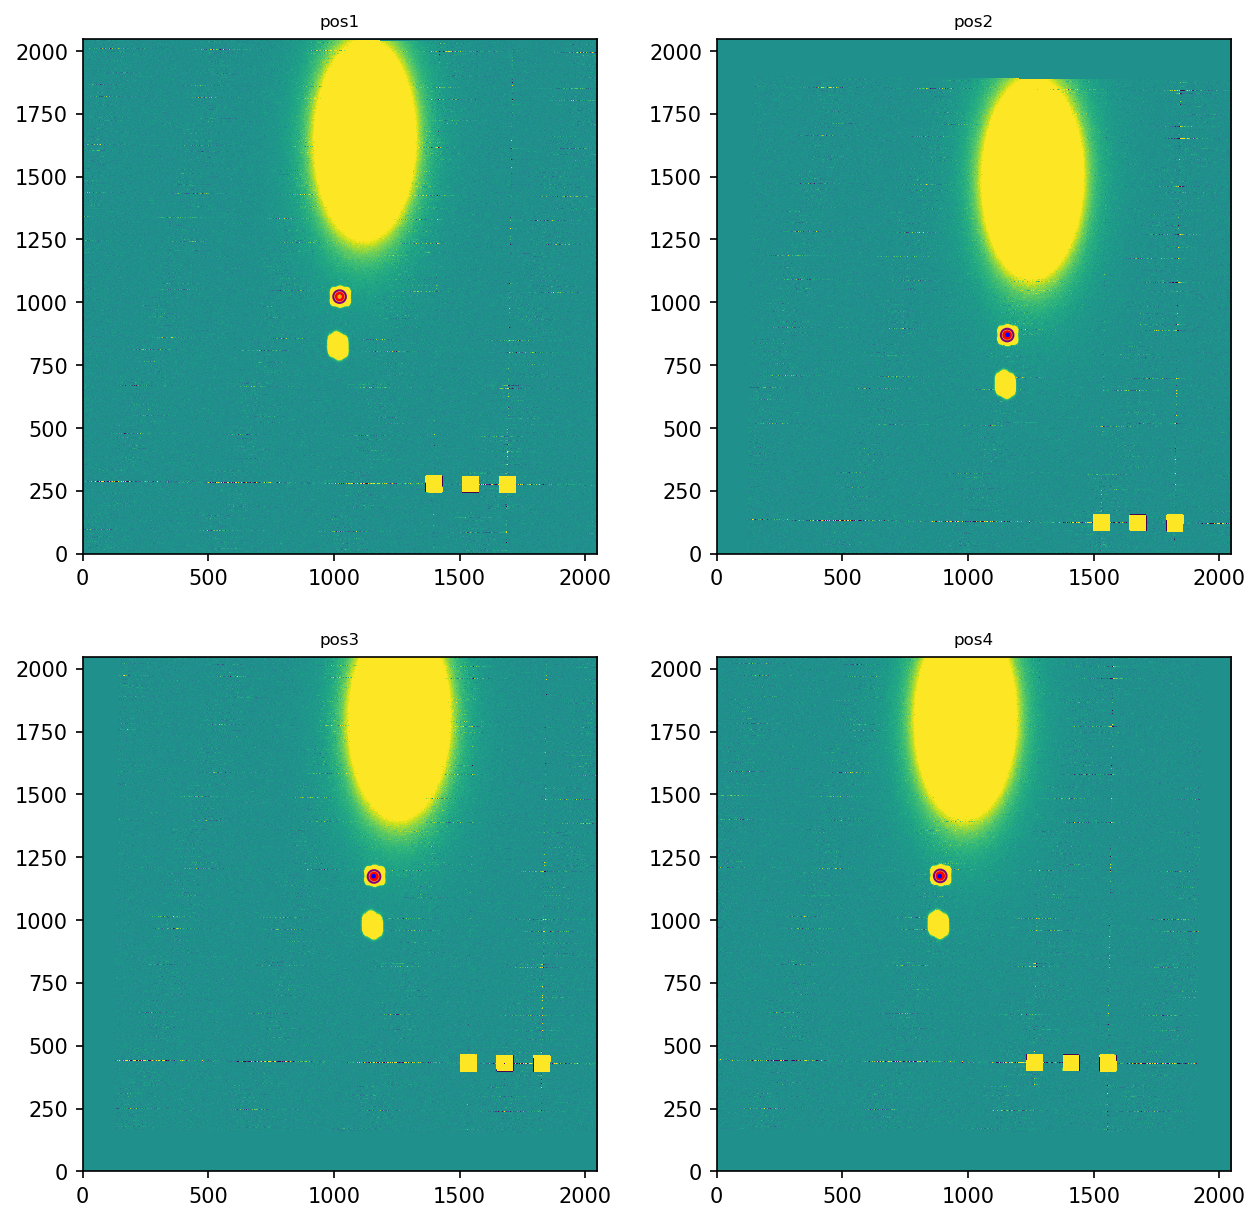

In [72]:
xs, ys = pos1_image.data.shape
fig = plt.figure(figsize=(10,10), dpi=150)

obj = catalog[4]
print("Object detected at {} {}".format(obj['xcentroid'].value, obj['ycentroid'].value))

ax = fig.add_subplot(2, 2, 1)
ax.set_title("pos1", fontsize=8)
ax.imshow(pos1_image.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)
plist = patches.Circle(pos1_image_wcs.meta.wcs.invert(ra, dec), 15, color='red')
ax.add_patch(plist)
junk = pos1_image_wcs.get_fits_wcs()
x,y = junk.all_world2pix(ra, dec,0)
print("{} {} --> {} {}".format(ra,dec,x,y))
ax.add_patch(patches.Circle((x, y), 5, color='blue'))
ax.add_patch(patches.Circle((obj['xcentroid'].value, obj['ycentroid'].value),5,color='orange'))
ax.add_patch(patches.Circle((pos1_image_wcs.meta.wcs.invert(53.090881064168535,-27.956434005390832)),25, color='purple', fill=False))


ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title("pos2", fontsize=8)
ax2.imshow(pos2_image.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)
plist = patches.Circle(pos2_image_wcs.meta.wcs.invert(ra, dec), 15, color='red')
ax2.add_patch(plist)
junk = pos2_image_wcs.get_fits_wcs()
x,y = junk.all_world2pix(ra, dec,0)
print("{} {} --> {} {}".format(ra,dec,x,y))
ax2.add_patch(patches.Circle((x,y), 5, color='blue'))
ax2.add_patch(patches.Circle((pos2_image_wcs.meta.wcs.invert(53.090881064168535,-27.956434005390832)),25, color='purple', fill=False))


ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title("pos3", fontsize=8)
ax3.imshow(pos3_image.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)
plist = patches.Circle(pos3_image_wcs.meta.wcs.invert(ra, dec), 15, color='red', )
ax3.add_patch(plist)
junk = pos3_image_wcs.get_fits_wcs()
x,y = junk.all_world2pix(ra, dec,0)
print("{} {} --> {} {}".format(ra,dec,x,y))
ax3.add_patch(patches.Circle((x,y), 5, color='blue'))
ax3.add_patch(patches.Circle((pos3_image_wcs.meta.wcs.invert(53.090881064168535,-27.956434005390832)),25, color='purple', fill=False))


ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title("pos4", fontsize=8)
ax4.imshow(pos4_image.data, origin='lower', extent=[0,xs,0,ys], vmin=-5e-6, vmax=5e-6)
plist = patches.Circle(pos4_image_wcs.meta.wcs.invert(ra, dec), 15, color='red')
ax4.add_patch(plist)
junk = pos4_image_wcs.get_fits_wcs()
x,y = junk.all_world2pix(ra, dec,0)
print("{} {} --> {} {}".format(ra,dec,x,y))
ax4.add_patch(patches.Circle((x,y), 5, color='blue'))
ax4.add_patch(patches.Circle((pos4_image_wcs.meta.wcs.invert(53.090881064168535,-27.956434005390832)),25, color='purple', fill=False))



## Overplot the ra,dec position from the resampled image catalog on the original raw scene image using just the fits wcs read by astropy wcs

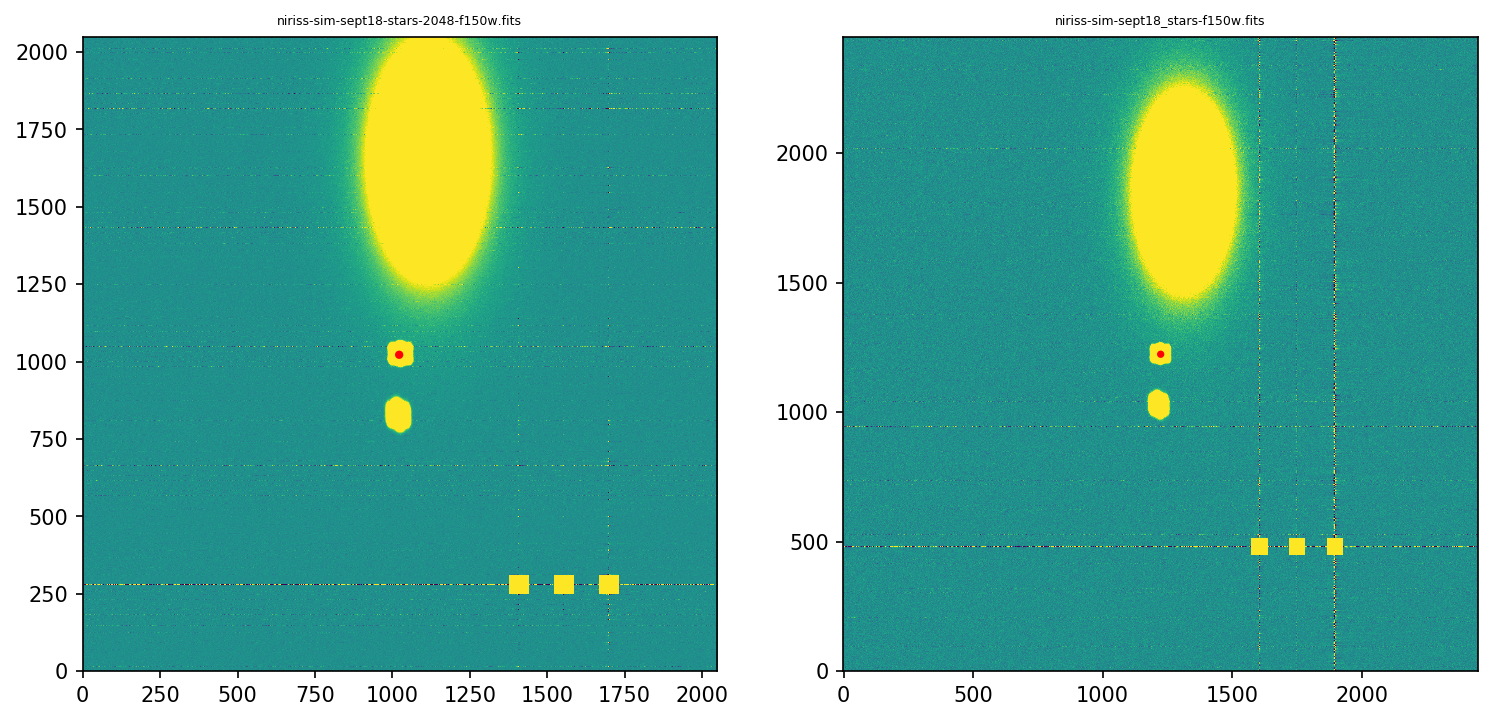

In [77]:
praw = fits.getdata(raw_scene)

large_raw = "../comparison/comparison/niriss-sim-sept18_stars-f150w.fits"
im_large_raw = fits.getdata(large_raw)

#xs, ys = dirim[1].data.shape
fig = plt.figure(figsize=(12,10), dpi=150)

ax = fig.add_subplot(1, 2, 1)
ax.set_title(raw_scene.split("/")[-1], fontsize=6)
ax.imshow(praw, origin='lower', vmin=-5e-6, vmax=5e-6)
junk = WCS(raw_scene)
x,y =junk.all_world2pix(53.090881064168535,-27.956434005390832, 0)
plist1=(patches.Circle((x,y),10, color='red'))
ax.add_patch(plist1)

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title(large_raw.split("/")[-1], fontsize=6)
ax2.imshow(im_large_raw, origin='lower', vmin=-5e-6, vmax=5e-6)
junk = WCS(large_raw)
x,y = junk.all_world2pix(53.090881064168535,-27.956434005390832, 0)
plist1=(patches.Circle((1224, 1224),10, color='red'))
ax2.add_patch(plist1)